In [1]:
import pandas as pd
import json

In [2]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

## Read Data

In [240]:
# main data
csv_file = 'data/EXPORT_09042017173622.csv'

# json files to translate gestures, parcours into long text
#gestures_file = 'data/gestures.json' # this is the file edited manually by us to conform to json
gestures_file = 'data/gestures.json.orig' # this is the file edited manually by us to conform to json
parcours_file = 'data/parcours.json'
mutations_file = 'data/mutations.json'

files = (gestures_file, parcours_file, mutations_file)
dataframes = []

# NOTE THAT THESE JSON FILES ARE NOT JSON CONFORM
# each line is a json string on its own, so we need to process the json line by line and combine THEN into a list

In [241]:
def get_oid(oid_dict):
    # get from the original representation {u'$oid': u'589c8ed31337b5ab1e1be121'} just the oid
    return oid_dict['$oid']

In [242]:
for filename in files:
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]   # .decode("utf-8")

    lines = [json.loads(line) for line in lines]
    
    # convert list of json lines into Dataframe
    df = pd.DataFrame.from_dict(lines)
    # convert long $oid to short
    df['_id'] = df['_id'].apply(get_oid)
    
    # set the real id
    df.set_index('id', inplace=True)
    
    dataframes.append(df)

In [324]:
(gestures_df, parcours_df, mutations_df) = tuple(dataframes)

In [325]:
gestures_df

,_id,isGarbage,isNesture,name,slug
id,,,,,
G01,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
G02,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
G03,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
G04,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
G05,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
G06,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
G07,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
G08,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
G09,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr


In [326]:
# "positive" gestures to recognize (not nestures)
gestures_pos = gestures_df[gestures_df['isNesture'] != True].index.tolist()

In [327]:
parcours_df

,_id,comment,exercises,pose
id,,,,
P101,589c897d1337b5ab1e1be118,Zwinge X locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P102,589c8ba71337b5ab1e1be11c,Zwinge X locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P103,589c8dbd1337b5ab1e1be11f,Zwinge X locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P104,589c8ed31337b5ab1e1be121,Zwinge X fest links- und rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P105,589c8fcc1337b5ab1e1be125,Zwinge X oszilierend linksdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P106,589c901a1337b5ab1e1be127,Zwinge X oszilierend rechtsdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P107,589c90e31337b5ab1e1be12c,Zwinge Y locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P108,589c911c1337b5ab1e1be12e,Zwinge Y locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P109,589c91961337b5ab1e1be132,Zwinge Y locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...


In [187]:
parcours_df.ix[0,'exercises']

[{u'mutation': {u'id': u'M151'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}}]

In [165]:
parcours_df.ix[0,'pose']

{u'start': u'Host 008 ist auf Werkbank fixiert, Griffachse X, untere Spannbacke fixiert (Xcm), Gewinde genau in Mitte. Subject steht frontal vor Werkbank, etwas links von Host, F\xfc\xdfe in Schulterbreite, Arme h\xe4ngen locker hinunter.'}

In [328]:
mutations_df

,_id,hands,params,slug
id,,,,
M101,58a24ffa5097dc5998d3c5d0,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabaaaba
M102,58a24ffa5097dc5998d3c5d1,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabababa
M103,58a24ffa5097dc5998d3c5d2,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbaaaba
M104,58a24ffa5097dc5998d3c5d3,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbababa
M105,58a24ffa5097dc5998d3c5d4,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaacbaabba
M106,58a24ffa5097dc5998d3c5d5,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaadbabbba
M107,58a24ffa5097dc5998d3c5d6,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabaaaba
M108,58a24ffa5097dc5998d3c5d7,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabababa
M109,58a24ffa5097dc5998d3c5d8,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaabbaaaba


In [195]:
mutations.ix['M101','hands']

{u'right': {u'gesture': {u'id': u'G01'},
  u'host': {u'id': u'H008',
   u'name': u'Schraubzwinge klein',
   u'spot': {u'id': u'A', u'name': u'Drehgriff'}},
  u'instruction': u'Zwinge X locker rechtsdrehen einzeln'}}

In [197]:
mutations.ix['M103','params']

[{u'label': u'K\xf6rperhaltung', u'slug': u'm0', u'value': u'stehend'},
 {u'label': u'Spot', u'slug': u'm1', u'value': u'Drehgriff'},
 {u'label': u'Position Spot', u'slug': u'm2', u'value': u'mittig vor Subject'},
 {u'label': u'Orientierung Spot', u'slug': u'm3', u'value': u'Griffachse X'},
 {u'label': u'ausf\xfchrende Hand', u'slug': u'm4', u'value': u'Rechte'},
 {u'label': u'Handhaltung', u'slug': u'm5', u'value': u'Faust'},
 {u'label': u'Widerstand', u'slug': u'm6', u'value': u'Anziehphase'},
 {u'label': u'Drehweise',
  u'slug': u'm7',
  u'value': u'ganze Hand mitbewegen, ganze Hand umgreifen'},
 {u'label': u'Drehwinkel', u'slug': u'm8', u'value': u'90\xb0'},
 {u'label': u'Drehrichtung',
  u'slug': u'm9',
  u'value': u'rechtsrum (schlie\xdfen)'},
 {u'label': u'Bewegungsablauf', u'slug': u'm10', u'value': u'einzeln'},
 {u'label': u'2. Hand', u'slug': u'm11', u'value': u'ruht woanders'}]

In [211]:
mutations.ix['M101','hands']['right']['gesture']['id']

u'G01'

### Define handy function shortcuts

In [329]:
def gesture_name(gesture_id):
    if gesture_id is None: return None
    return gestures_df.loc[gesture_id,'name']

In [330]:
def get_mutation_gesture(mutation_id):
    return mutations_df.ix[mutation_id,'hands']['right']['gesture']['id']

## Read Experiment Data

In [7]:
# Experiment Data
data = pd.read_csv(csv_file)
data.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1435576, 26)

In [8]:
data.shape

(1435576, 26)

In [9]:
data.columns

Index([u'Trainset-ID', u'Experiment-ID', u'Subject-ID', u'Observer-ID',
       u'collectedByHand', u'Collector-ID', u'TimeStamp', u'RFID-ID',
       u'GRASP-A', u'GRASP-B', u'GRASP-C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'USERINPUT', u'HANDINGLOVE', u' Parcours-ID', u'Parcours-Step',
       u'Mutation-ID', u' Mutation/HandIsActive', u'Host-ID', u'Host/Spot-ID',
       u'Gesture-ID'],
      dtype='object')

In [10]:
data.head()

,Trainset-ID,Experiment-ID,Subject-ID,Observer-ID,collectedByHand,Collector-ID,TimeStamp,RFID-ID,GRASP-A,GRASP-B,...,EZ,USERINPUT,HANDINGLOVE,Parcours-ID,Parcours-Step,Mutation-ID,Mutation/HandIsActive,Host-ID,Host/Spot-ID,Gesture-ID
0,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,0,000000000000,781,8,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
1,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,19896,000000000000,212,213,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
2,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,29001,000000000000,782,0,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
3,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,29823,000000000000,179,185,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
4,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,46136,000000000000,782,6,...,-81.8750,False,True,P101,1,M151,True,H008,NaN,G15


## Some Data Stats

In [311]:
# how many subjects
subjects = data['Subject-ID'].unique().tolist()
subjects 

['Andreas', 'Alfred', 'Claudia', 'Dominik']

In [12]:
# how many observers
data['Observer-ID'].unique().tolist()

['Clemens']

In [13]:
# how many hands
data['Collector-ID'].unique().tolist()

['R01', 'L01']

In [14]:
# how many RFID ids
data['RFID-ID'].unique().tolist()

['000000000000',
 '09006734114B',
 0,
 '05003DD5CD20',
 '760057911BAB',
 '13005E4BB7B1',
 '1400135B8AD6',
 '14001486BE38',
 '7600577D0D51',
 '140014CD1AD7',
 '280015E55981',
 '05008C2F993F']

In [314]:
# how many experiments
experiments = data['Experiment-ID'].unique().tolist()
experiments

['E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008']

In [16]:
# how many training sets
len(data['Trainset-ID'].unique().tolist())

539

In [17]:
# how many parcours
len(data[' Parcours-ID'].unique())

116

In [18]:
data[' Parcours-ID'].unique()

array(['P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108',
       'P109', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116',
       'P117', 'P118', 'P401', 'P402', 'P403', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'P207', 'P208', 'P211', 'P212', 'P213',
       'P216', 'P217', 'P218', 'P221', 'P222', 'P223', 'P226', 'P227',
       'P228', 'P701', 'P702', 'P705', 'P706', 'P709', 'P710', 'P713',
       'P714', 'P801', 'P802', 'P601', 'P602', 'P603', 'P606', 'P607',
       'P608', 'P611', 'P612', 'P613', 'P616', 'P617', 'P618', 'P621',
       'P622', 'P623', 'P501', 'P502', 'P504', 'P503', 'P301', 'P302',
       'P306', 'P307', 'P308', 'P311', 'P312', 'P316', 'P317', 'P318',
       'P321', 'P322', 'P326', 'P327', 'P328', 'P119', 'P120', 'P121',
       'P231', 'P232', 'P234', 'P233', 'P236', 'P235', 'P717', 'P718',
       'P719', 'P720', 'P721', 'P722', 'P723', 'P724', 'P626', 'P627',
       'P628', 'P629', 'P630', 'P331', 'P332', 'P333', 'P334', 'P335',
      

In [19]:
# how many parcours steps
data['Parcours-Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [20]:
# how many mutations
len(data['Mutation-ID'].unique())

177

In [21]:
# how many gestures
len(data['Gesture-ID'].unique())

19

In [86]:
# which gestures exist
sorted(data['Gesture-ID'].unique())

['G01',
 'G02',
 'G03',
 'G04',
 'G05',
 'G06',
 'G07',
 'G08',
 'G09',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'G15',
 'G16',
 'G17']

In [22]:
# how many hosts
len(data['Host-ID'].unique())

10

In [23]:
# which Host Spots
data['Host/Spot-ID'].unique().tolist()

[nan, 'A', 'B', 'F']

## Data Preprocessing

In [39]:
# rename some columns as the - in the column name does not allow for data.query()) to be used
# cut off the "-ID" suffix and replace - by _

for col in data.columns:
    if col.endswith('-ID'):
        data.rename(columns={col: col[:-3]}, inplace=True)
        print "Renamed", col, "->", col[:-3]
        col = col[:-3]
    if col.startswith(' '):
        data.rename(columns={col: col[1:]}, inplace=True)
        print "Renamed", col, "->", col[1:]
        col = col[1:]
    if '-' in col:
        new_col = col.replace('-','_')
        data.rename(columns={col: new_col}, inplace=True)
        print "Renamed", col, "->", new_col

Renamed  Parcours -> Parcours


/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [25]:
# remove rows that are not needed:
# all where Gesture-ID is NaN  (implies 'Mutation/HandIsActive' == False and Host is NaN)

data.dropna(axis=0, subset=['Gesture'], inplace=True)

In [27]:
# remove columns that we don't need
# to be ignored as communicated by MOM
cols_to_remove = ['Trainset','USERINPUT', 'HANDINGLOVE', 'Observer','Collector','RFID','Parcours_Step',
                  'Mutation/HandIsActive']

data.drop(cols_to_remove,inplace=True,axis=1)

In [28]:
data.shape

(780299, 18)

In [29]:
data

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15
10,E001,Andreas,right,116448,784,4,800,0.12,-0.06,-0.03,218.3125,9.2500,-81.7500,P101,M151,H008,NaN,G15
12,E001,Andreas,right,148753,783,0,798,0.21,-0.04,0.03,218.5000,9.3125,-81.7500,P101,M151,H008,NaN,G15
14,E001,Andreas,right,167422,784,2,798,0.18,-0.10,-0.08,218.6875,9.3750,-81.7500,P101,M151,H008,NaN,G15
16,E001,Andreas,right,187481,782,4,799,0.15,-0.18,-0.03,219.0000,9.4375,-81.7500,P101,M151,H008,NaN,G15
18,E001,Andreas,right,213733,784,13,799,0.15,-0.18,-0.17,219.1250,9.4375,-81.7500,P101,M151,H008,NaN,G15


In [30]:
# also in this evaluation, we use only one-hand devices and only people who are right-handers
data['collectedByHand'].unique().tolist()

['right', 'left']

In [31]:
sum(data['collectedByHand']=='right')

711360

In [32]:

sum(data['collectedByHand']=='left')

68939

In [33]:
# filter right hand, throw away left hand
data = data[data['collectedByHand']=='right']

## Look into the Data

In [40]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15


In [41]:
data.columns

Index([u'Experiment', u'Subject', u'collectedByHand', u'TimeStamp', u'GRASP_A',
       u'GRASP_B', u'GRASP_C', u'AX', u'AY', u'AZ', u'EX', u'EY', u'EZ',
       u'Parcours', u'Mutation', u'Host', u'Host/Spot', u'Gesture'],
      dtype='object')

### Get Experiment data: Filter for one experiment of one subject

In [335]:
def get_experiment(data,experiment,subject,parcours,mutation,gesture):
    query = []
    # by passing None, some parts of these can be omitted (returning more data)
    if experiment: query.append('Experiment==@exp')
    if subject: query.append('Subject==@subject')
    if parcours: query.append('Parcours==@parcours')
    if mutation: query.append('Mutation==@mutation')
    if gesture: query.append('Gesture==@gesture')
    # TODO filter by Parcours_Step u/o Host
    
    query = " and ".join(query)
    #print query
    return data.query(query)


In [323]:
# get experiment data (setting one to None does not filter by it)
exp = 'E001'
subject = 'Andreas'
parcours = 'P102'
mutation = None
gesture = None #'G02' #'G01'

mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)
mydata.shape

Experiment==@exp and Subject==@subject and Parcours==@parcours


(0, 18)

In [320]:
# if we queried without Parcours, use this to get all the Parcours
mydata['Parcours'].unique().tolist()

['P102']

In [321]:
mut_list = mydata['Mutation'].unique().tolist()
mut_list

['M151', 'M102', 'M153']

In [322]:
gest_list = mydata['Gesture'].unique().tolist()
gest_list

['G15', 'G02', 'G17']

In [300]:
for mut in mut_list:
    gest = get_mutation_gesture(mut)
    print mut, ":", gest, gesture_name(gest)

M102 : G02 Single Rotation klein linksrum


In [301]:
get_experiment(data,exp,subject,parcours,mutation=None,gesture='G15')



Experiment==@exp and Subject==@subject and Parcours==@parcours and Gesture==@gesture


,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
2477,E001,Andreas,right,0,790,10,809,1.29,0.15,-0.24,236.0000,4.1250,-82.5000,P102,M151,H008,NaN,G15
2480,E001,Andreas,right,31090,789,0,807,1.53,0.39,0.19,236.0625,3.7500,-83.0625,P102,M151,H008,NaN,G15
2482,E001,Andreas,right,55174,789,0,808,1.14,0.62,0.64,235.9375,3.5625,-83.7500,P102,M151,H008,NaN,G15
2484,E001,Andreas,right,77280,788,12,808,1.07,0.44,0.63,235.8125,3.6250,-83.8750,P102,M151,H008,NaN,G15
2485,E001,Andreas,right,97476,789,9,808,1.02,0.30,0.53,235.5625,3.8125,-83.8125,P102,M151,H008,NaN,G15
2486,E001,Andreas,right,113645,791,0,809,0.54,0.00,0.17,235.1250,4.0000,-83.5625,P102,M151,H008,NaN,G15
2489,E001,Andreas,right,135236,791,5,809,0.25,-0.15,0.10,234.6250,4.1250,-83.3125,P102,M151,H008,NaN,G15
2491,E001,Andreas,right,166211,788,0,809,-0.19,-0.06,0.21,234.0000,4.1875,-83.1875,P102,M151,H008,NaN,G15
2493,E001,Andreas,right,183683,789,0,809,-0.41,0.01,0.40,233.3125,4.1875,-83.0000,P102,M151,H008,NaN,G15
2496,E001,Andreas,right,224902,790,9,809,-0.40,0.14,0.44,232.6875,4.1875,-82.9375,P102,M151,H008,NaN,G15


### Check TimeStep deltas

In [289]:
def one_plot(mydata,var):
    y = mydata[var]
    x = range(len(y))
    #x = mydata['TimeStamp']
    plt.plot(x, y)
    title = "%s %s %s %s %s %s" % (exp,subject,parcours,mutation,gesture,gesture_name(gesture)) 
    plt.title(title)
    #plt.show()

In [290]:
# investigate time stamp mean and variance
mydata['TimeStamp'].diff().describe()

count       663.000000
mean      27686.944193
std       35440.604695
min         957.000000
25%       17415.500000
50%       24060.000000
75%       28759.000000
max      333752.000000
Name: TimeStamp, dtype: float64

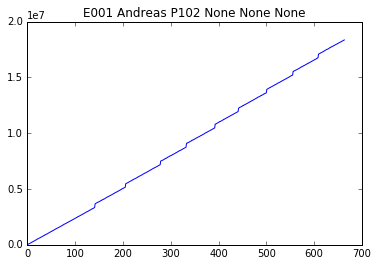

In [295]:
var = 'TimeStamp'
one_plot(mydata,var)

#### TODO: Should we interpolate by event timestamps?


### Visualize timeline of sensor data of an experiment

In [307]:
# TODO GRASP_A B C
params = ['AX', 'AY', 'AZ', 'EX', 'EY', 'EZ']

In [264]:
def grid_plot(mydata):
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10)) #, sharex=True, sharey=True)
    title = "%s %s %s %s %s %s" % (exp,subject,parcours,mutation,gesture,gesture_name(gesture)) 
    fig.suptitle(title, fontsize=16)

    axes_list = axes.reshape(-1)

    for i, var in enumerate(params):

        # data
        y = mydata[var]
        x = range(len(y))
        #x = mydata['TimeStamp']

        # subplot index
        r = i % rows
        c = int(i / rows)
        axes[r,c].plot(x, y)
        axes[r,c].set_title(var)
    

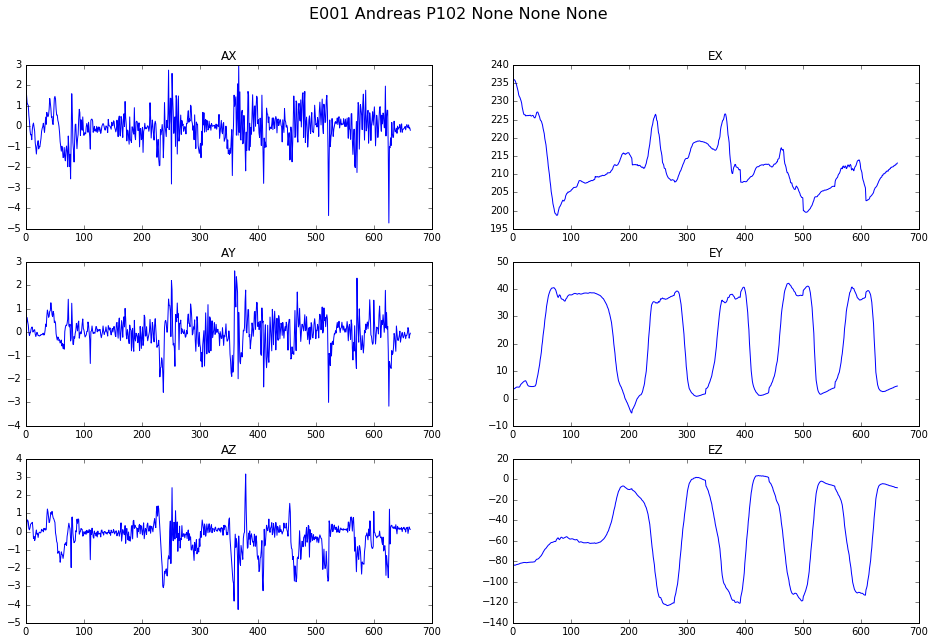

In [296]:
grid_plot(mydata)

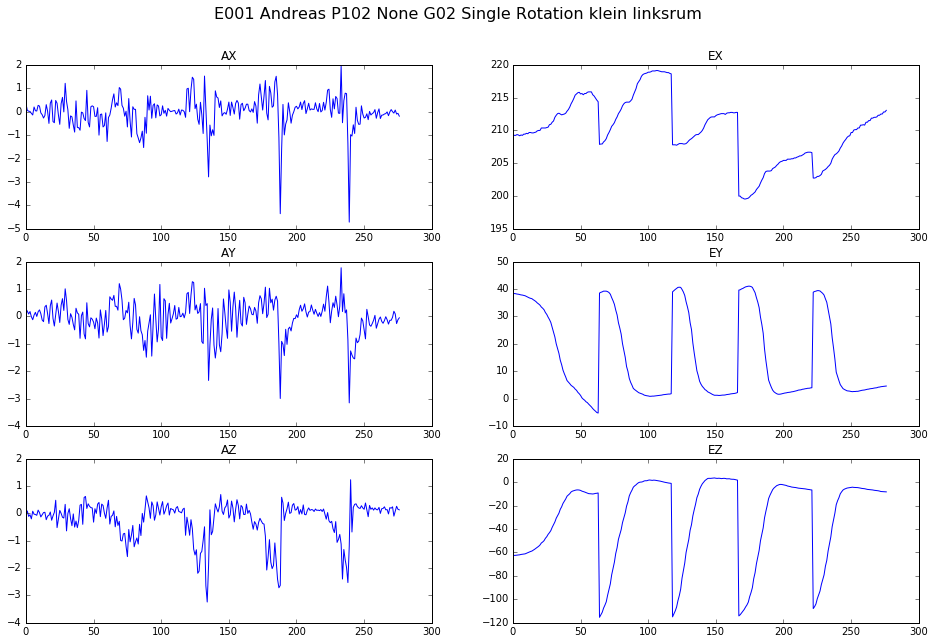

In [302]:
grid_plot(mydata)

In [309]:
gestures_pos

[u'G01',
 u'G02',
 u'G03',
 u'G04',
 u'G05',
 u'G06',
 u'G07',
 u'G08',
 u'G09',
 u'G10',
 u'G11',
 u'G12',
 u'G13']

In [ ]:
# Make groupings by Subject, Experiment, 

In [ ]:
# Iterate over Experiments etc. to group data by gestures

experiments = data['Experiment'].unique().tolist()



In [336]:
# dictionary containing a list of sub-datasets for each gesture, to train ML
gesture_exp_dict = {}

In [344]:
for subject in subjects:
    for exp in experiments:
        
        exp_data = get_experiment(data,exp,subject,parcours=None,mutation=None,gesture=None)
        
        if exp_data.shape[0] > 0:
            # list of parcours in this experiment
            parc_list = exp_data['Parcours'].unique().tolist()
            
            print subject, exp, ":", len(parc_list), "parcours"

#            for parc in parc_list:
            for parc in parc_list[:5]:     # DEBUG: take only first 5 parcours per experiment
                mydata = get_experiment(data,exp,subject,parc,mutation=None,gesture=None)
                mutations = exp_data['Mutation'].unique().tolist()
                gestures = exp_data['Gesture'].unique().tolist() 
                
                print "-", parc, mydata.shape, len(mutations), "mutations", len(gestures), "gestures"
                
                for mut in mutations:
                    mydata = get_experiment(data,exp,subject,parc,mut,gesture=None)
                    gestures = mydata['Gesture'].unique().tolist() 
                    
                    for gest in gestures:
                        mydata = get_experiment(data,exp,subject,parc,mut,gest)
                        print mydata.shape
                        # add data to gesture dict
                        if mydata.shape[0] > 0:
                            if gest not in gesture_exp_dict.keys():
                                gesture_exp_dict[gest] = [] # initalize empty list for this gesture
                            # add data to gesture dict
                            gesture_exp_dict[gest].append(mydata)

Andreas E001 : 57 parcours
- P101 (1238, 18) 89 mutations 10 gestures
(245, 18)
(626, 18)
(367, 18)
- P102 (664, 18) 89 mutations 10 gestures
(195, 18)
(277, 18)
(192, 18)
- P103 (845, 18) 89 mutations 10 gestures
(217, 18)
(362, 18)
(266, 18)
- P104 (889, 18) 89 mutations 10 gestures
(102, 18)
(445, 18)
(342, 18)
- P105 (2368, 18) 89 mutations 10 gestures
(495, 18)
(1873, 18)
Andreas E006 : 59 parcours
- P611 (1205, 18) 111 mutations 17 gestures
(146, 18)
(150, 18)
(417, 18)
(492, 18)
- P612 (816, 18) 111 mutations 17 gestures
(128, 18)
(81, 18)
(286, 18)
(321, 18)
- P613 (889, 18) 111 mutations 17 gestures
(111, 18)
(95, 18)
(381, 18)
(302, 18)
- P616 (1014, 18) 111 mutations 17 gestures
(91, 18)
(200, 18)
(300, 18)
(423, 18)
- P617 (791, 18) 111 mutations 17 gestures
(104, 18)
(79, 18)
(311, 18)
(297, 18)
Alfred E002 : 77 parcours
- P101 (720, 18) 115 mutations 10 gestures
(142, 18)
(268, 18)
(310, 18)
- P102 (531, 18) 115 mutations 10 gestures
(142, 18)
(204, 18)
(185, 18)
- P103 (

In [345]:
for gest in sorted(gesture_exp_dict.keys()):
    print gest, len(gesture_exp_dict[gest]), "data blocks"

G01 16 data blocks
G02 12 data blocks
G03 15 data blocks
G04 16 data blocks
G05 3 data blocks
G06 3 data blocks
G15 41 data blocks
G16 11 data blocks
G17 16 data blocks


In [ ]:
# Standardize

In [ ]:
# Time Normalize? / Interpolate time stamps

In [ ]:
# Calc derivatives

In [ ]:
# Sliding Window

## Tasks

### 1) Recognize Host + Gesture

(maybe also Subject)

### 2) Recognize Gesture independent of host